# Introduction
This is a draft report for the final course project.

- **Team 97:** Cody Talmadge(codytt2@illinois.edu), Seth Joslin (sjoslin2@illnois.edu), and Sree Alaparthi (sa68@illinois.edu)
- **Paper 33 - ScoEHR**: Generating Synthetic Electronic Health Records using Continuous-time Diffusion Models[1]
- **Github:** [https://github.com/sjoslin2/Spring-24-DLH](https://github.com/sjoslin2/Spring-24-DLH)


*   **Background of the problem**

    Patient health data, mainly kept in electronic health records (EHRs), plays a crucial role in the healthcare sector, with its increase in usage rates in hospitals across both the US and UK. EHRs include both structured and unstructured data, from patient demographics to medical images, enabling extensive analysis to unveil disease progression and health trends. Leveraging EHRs, predictive and prescriptive machine learning models have revolutionized patient care, predicting outcomes and disease severity with high accuracy. However, sharing EHRs remains constrained by regulatory frameworks like HIPAA and GDPR, compounded by challenges in aggregating EHRs due to varying standards and policies. Synthetic data generation offers a solution, addressing access and bias issues. However, generating synthetic EHRs is complex due to high dimensionality and data heterogeneity. While  generative Adversarial Networks (GANs) have been popular, they face challenges like mode collapse and unstable training. Recently, diffusion models have emerged as promising alternatives, offering stable training and high-fidelity data synthesis, making them ideal for synthetic EHR generation.


*   **Paper explanation**

    This paper introduces ScoEHR, a synthetic EHR generation framework employing continuous-time diffusion models. ScoEHR combines an autoencoder with a continuous-time diffusion model.The ScoEHR transforms real data into a low-dimensional space through an encoder from a pre-trained autoencoder. Within this low-dimensional space, a forward stochastic differential equation (SDE) diffuses the data. Subsequently, a reverse SDE is learned and applied to generate new synthetic data. This synthetic data is then transformed using the decoder from the autoencoder to produce the final synthetic EHR data.
    ScoEHR was compared to medGAN, medWGAN, and medBGAN using the following four performance metrics of data generation utility:
     
    *   Preservation of feature marginal relationships,
    *   Preservation of feature correlations,
    *   Preservation of full feature distribution using log-clusters,
    *   Synthetic data performance in downstream predictions of patient outcomes.

    Additionally, Physician evaluation confirms its realism, establishing ScoEHR as the current state-of-the-art in synthetic EHR generation.

# Scope of Reproducibility:
There are two central hypotheses that were tested as a part of this paper: ScoEHR produces higher-quality synthetic data than the previously-leading synthetic EHR models and United States board-certified physicians cannot differentiate between the synthetic data produced by ScoEHR and real EHR data.


1.   **Hypothesis 1:**
 - **Hypothesis:** The first hypothesis was tested by comparing ScoEHR against the three-leading synthetic EHR models (medGAN [2], medWGAN [3], and medBGAN[3]) on four key areas: preservation of feature marginal relationships, preservation of feature correlations, preservation of full feature distributing using log-clusters, and synthetic data performance in downstream predictions of patient outcomes.
 - **Scope of Reproducibility:** We made an initial attempt to partially replicate the aforementioned hypothesis using the MIMIC-III dataset, however, the outcomes are not same as the results provided in the paper. We are committed to further refining our approach to improve the consistency of results.

2.   **Hypothesis 2:**
 - **Hypothesis:** The second hypothesis was tested by presenting both synthetic and real EHR data to physicians and asking them to identify the “real” data. By looking at what portion of synthetic data they identified as “real” and comparing it with the portion of real data they identified as “real” the authors were able to determine that physicians were not able to tell the difference between the synthetic and real data.
 - **Scope of Reproducibility:** This hypothesis might be unfeasible without real doctors available to validate the authenticity of synthetic records.

# Methodology

The Methodology section consists of 5 sub-sections:
- Setup
- Data
- Model
- Training
- Generate Synthetic Data
- Evaluation

For each sub-section, a description/explanation of that sub-section is given as well as implementation code.

##Setup
###Manual Setup Needed
In order to run this notebook, you will need to:
1. Ensure that you downloaded it from the [github repository](https://github.com/sjoslin2/Spring-24-DLH).  This means that you should see the following folders:
 - `./mimic/` - Empty folder where you need to manually add the MIMIC-III data files (detailed instructions in Data sub-section).
 - `./saved_models/` - This is where the saved Autoencoder and Score Net model parametres live.  Training these models from scratch instead requires ~30 minutes of GPU time.
 - `./stats/` - This contains stats information around the model training.  If you train these models from scratch then your model trainings stats are displayed instead.
 - `./generated_data/` - This contains synthetic data generated by the model.  If you want to generate your own synthetic data you'll need ~30 minutes of GPU time.
2. Ensure you have added the MIMIC-III data files into the `./mimic/` folder (detailed instructions in the Data sub-section).

###Setup Code
The setup section installs all required modules and imports them for later use.

In [8]:
!pip install torchsde

In [9]:
import torch
import os
import tqdm
import math
import time
import torchsde

import numpy as np
import torch.nn.functional as F
import _pickle as pickle

from torch import nn
from torch.utils.data import DataLoader
from torch.nn.init import _calculate_fan_in_and_fan_out
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from datetime import datetime
from matplotlib import pyplot
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

##  Data
We are using MIMIC-III dataset from physionet -> https://physionet.org/content/mimiciii/1.4/.

Please follow the instructions in piazza post #338 to access the MIMIC-III dataset. Download and decompress the following two csv files and place them in the `./mimic` folder:
- `ADMISSIONS.csv`
- `DIAGNOSES_ICD.csv`

The code below converts the MIMIC-III data set into a .matrix file that consists of one row per patient and one column per ICD code (treated later as features).  Each row has a `1` in the column if that patient EHR has that column's ICD code in at least one of their visits, and a `0` in the column if that patient's EHR never shows the ICD code in any visits.

Set `generate_matrix_file = True` (default) to generate the preprocessed `.matrix` file required for training the model and/or comparing the real and synthetic data).

In [10]:
# Modified from: https://github.com/mp2893/medgan/blob/master/process_mimic.py

generate_matrix_file = True

admissionFile = './mimic/ADMISSIONS.csv'
diagnosisFile = './mimic/DIAGNOSES_ICD.csv'
outFile = './mimic/mimic_processed_choi.matrix'

def convert_to_icd9(dxStr):
    if dxStr.startswith('E'):
        if len(dxStr) > 4: return dxStr[:4] + '.' + dxStr[4:]
        else: return dxStr
    else:
        if len(dxStr) > 3: return dxStr[:3] + '.' + dxStr[3:]
        else: return dxStr

if generate_matrix_file:
    binary_count = 'binary'

    print('Building pid-admission mapping, admission-date mapping')
    pidAdmMap = {}
    admDateMap = {}
    infd = open(admissionFile, 'r')
    infd.readline()
    for line in infd:
        tokens = line.strip().split(',')
        pid = int(tokens[1])
        admId = int(tokens[2])
        admTime = datetime.strptime(tokens[3], '%Y-%m-%d %H:%M:%S')
        admDateMap[admId] = admTime
        if pid in pidAdmMap: pidAdmMap[pid].append(admId)
        else: pidAdmMap[pid] = [admId]
    infd.close()

    print('Building admission-dxList mapping')
    admDxMap = {}
    infd = open(diagnosisFile, 'r')
    infd.readline()
    for line in infd:
        tokens = line.strip().split(',')
        admId = int(tokens[2])
        # Uncomment this line and comment the line below, if you want to use the entire ICD9 digits.
        dxStr = 'D_' + convert_to_icd9(tokens[4][1:-1])
        #dxStr = 'D_' + convert_to_3digit_icd9(tokens[4][1:-1])
        if admId in admDxMap: admDxMap[admId].append(dxStr)
        else: admDxMap[admId] = [dxStr]
    infd.close()

    print('Building pid-sortedVisits mapping')
    pidSeqMap = {}
    for pid, admIdList in pidAdmMap.items():
        #if len(admIdList) < 2: continue
        sortedList = sorted([(admDateMap[admId], admDxMap[admId]) for admId in admIdList])
        pidSeqMap[pid] = sortedList

    print('Building pids, dates, strSeqs')
    pids = []
    dates = []
    seqs = []
    for pid, visits in pidSeqMap.items():
        pids.append(pid)
        seq = []
        date = []
        for visit in visits:
            date.append(visit[0])
            seq.append(visit[1])
        dates.append(date)
        seqs.append(seq)

    print('Converting strSeqs to intSeqs, and making types')
    types = {}
    newSeqs = []
    for patient in seqs:
        newPatient = []
        for visit in patient:
            newVisit = []
            for code in visit:
                if code in types:
                    newVisit.append(types[code])
                else:
                    types[code] = len(types)
                    newVisit.append(types[code])
            newPatient.append(newVisit)
        newSeqs.append(newPatient)

    print('Constructing the matrix')
    numPatients = len(newSeqs)
    numCodes = len(types)
    matrix = np.zeros((numPatients, numCodes)).astype('float32')
    for i, patient in enumerate(newSeqs):
        for visit in patient:
            for code in visit:
                if binary_count == 'binary':
                    matrix[i][code] = 1.
                else:
                    matrix[i][code] += 1.

    pickle.dump(matrix, open(outFile, 'wb'), -1)
    print('Matrix construction complete')

Building pid-admission mapping, admission-date mapping
Building admission-dxList mapping
Building pid-sortedVisits mapping
Building pids, dates, strSeqs
Converting strSeqs to intSeqs, and making types
Constructing the matrix
Matrix construction complete


###Define DataLoader Class
Used to create Datasets and Dataloaders to pull data from the generated `.matrix` file

In [11]:
# Modified from https://github.com/aanaseer/ScoEHR/blob/main/scoehr/datasets.py

class Dataset():
    def __init__(self, data_dir, data_file):
        pass

    def data(self, use_train_test_split=True, test_size=0.30):
        if use_train_test_split:
            train_data, test_data = train_test_split(
                self.dataset_full, test_size=test_size
            )
            return train_data, test_data
        else:
            return self.dataset_full

class MIMIC3_ICD(Dataset):
    def __init__(
        self, data_dir="mimic", data_file="mimic_processed_choi.matrix"
    ):
        """Loads the MIMIC-III dataset from the data directory."""
        data_path = os.path.join(data_dir, data_file)
        data = np.load(data_path, allow_pickle=True)
        self.dataset_full = torch.from_numpy(data)

### Load the Data
Load the `.matrix` file and generated train and test dataloaders.

In [12]:
# Modified from: https://github.com/aanaseer/ScoEHR/blob/main/scoehr/main.py

load_data = True

batch_size = 512

if load_data:

    data_dir = './mimic/'
    data_file = 'mimic_processed_choi.matrix'

    train_data, test_data = MIMIC3_ICD(data_dir=data_dir, data_file=data_file).data()

    train_data = train_data.to(device)
    test_data = test_data.to(device)

    train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, drop_last=True)
    test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True, drop_last=True)
    print("Train Data Shape: ", train_data.shape)
    print("Test Data Shape: ", test_data.shape)

Train Data Shape:  torch.Size([32564, 6985])
Test Data Shape:  torch.Size([13956, 6985])


##   Model Part 1 - Autoencoder

###Overview
The synthetic generation process involves two different models:
- Autoencoder - Used to lower the dimensionality of the data
- Continuous-Time Diffusion Model - Used to generated synthetic data

The Autoencoder is used to lower the dimensionality from the original dataset (one feature per ICD code or 6,985 features) to 144 features.  This helps to capture relationships between related ICD codes and reduces the dimensionality of the output data that the continuous-time diffusion model must generate.

The Autoencoder is first trained and tested by itself to ensure that the Autoencoder model is able to successfully reduce the dimensionality of the data and then reproduce that original data using the reduced dimensionality dataset.  Then, the training data is encoded using the autoencoder and the encoded training data is used to train the Continuous-Time Diffusion model.  

This allows the Continous-Time Diffusion model to generate synthetic data in the lower dimensionality space.  This synthetic data is then decoded using the trained Autoencoder to generate synthetic data in a feature space that is tied back to ICD codes.

###Autoencoder Configuration

**Model Architecture:**

Layers | Configuration | Activation Function | Output Dimension (batch, feature)
--- | --- | --- | ---
fully connected | input size 6985, output size 144 | Tahnh | (512, 144)
fully connected | input size 144, output size 6985 | Sigmoid | (512, 6985)

**Training Objectives:**
- Loss Function: torch.nn.BCELoss with `reduction="sum"`
- Optimiser: torch.optim.Adam with `weight_decay=0.0001`

**Other Info:**
The model is not pretrained, but weights are initiatlized using `torch.nn.init.xavier_uniform_`.  The autoencoder post-encoding dimension of 144 was chosen by the original paper because previous papers indicated that 128 was the ideal post-encoding dimension, and 144 was the closest that worked with the UNet architecture of the upcoming Continous-Time Diffusion model.

### Define Autoencoder Class

In [13]:
# Modified from: https://github.com/aanaseer/ScoEHR/blob/main/scoehr/models/autoencoder.py

class Autoencoder(nn.Module):
    def __init__(self, enc_in_dim, enc_out_dim):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(nn.Linear(enc_in_dim, enc_out_dim), nn.Tanh())
        self.decoder = nn.Sequential(nn.Linear(enc_out_dim, enc_in_dim), nn.Sigmoid())

    def encode(self, x):
        x = self.encoder(x)
        return x

    def decode(self, x):
        x = self.decoder(x)
        return x

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Define weight initialization

In [14]:
def weights_init(m):
    # From https://github.com/astorfi/cor-gan/blob/b6df51a16399335bfe995c15b6951f053453fbb3/Generative/medGAN/MIMIC/pytorch/MLP/medGAN.py#L263 # noqa: E501
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

## Training Part 1 - Autoencoder

###Training Methodology
The model is trained with 200 epochs with a learning rate of 0.001.  This learning rate was from the original code while the number of epochs was determined empirically.  As can be seen in the per-epoch training loss chart displayed when the next cell is run, the number of epochs to successfully train is likely lower (there appear to be diminishing returns after ~125 epochs), however 200 epochs does not appear to cause significant overfitting issues as the test loss never increases.


###Computational Requirements
The training process takes several minutes when trained with a GPU (substantially longer on a CPU).  We were able to successfully train it on a machine with 16GB of RAM.

Because of the several-minute training time, by default this notebook is set to show stats from our training run (and load the model's parameters from the saved parameter file: `./saved_models/autoencoder.pt`).  If you'd like to change this to train it yourself, set `train_autoencoder_model = True`.  You can also overwrite our training parameters by setting `save_autoencoder_model = True`.

===> Loading trained model
===> Showing stats from loaded model


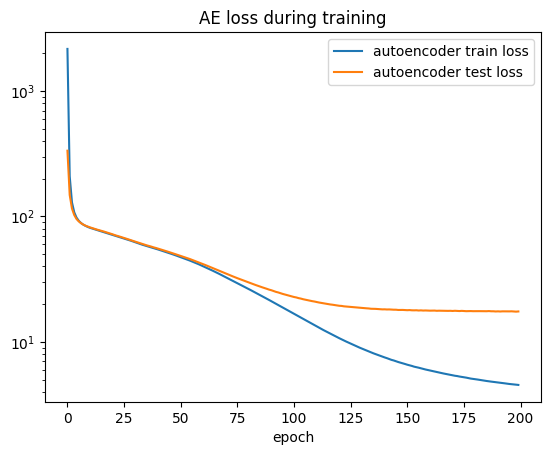

In [15]:
# Modified from: https://github.com/aanaseer/ScoEHR/blob/main/scoehr/train/train_autoencoder_utils.py

train_autoencoder_model = False
save_autoencoder_model = False

n_epochs_autoencoder = 200

lr_autoencoder = 0.001

if train_autoencoder_model:
    enc_in_dim = train_data.shape[1]
else:
    enc_in_dim = 6985

enc_out_dim = 144

autoencoder = Autoencoder(enc_in_dim, enc_out_dim)
autoencoder.to(device)
autoencoder.apply(weights_init)
optimiser_autoencoder = torch.optim.Adam(autoencoder.parameters(), lr=lr_autoencoder, weight_decay=0.0001)
loss_fn_instance_autoencoder = torch.nn.BCELoss(reduction="sum")  # WORKS FOR BINARY DATA!

if train_autoencoder_model:
    print(f"==> Training the autoencoder with {n_epochs_autoencoder} epochs.")
    epoch_train_loss_list = []
    epoch_test_loss_list = []
    for epoch in tqdm.tqdm(range(n_epochs_autoencoder)):
        epoch_train_loss = 0
        epoch_test_loss = 0
        autoencoder.train()
        for x in train_dataloader:
            optimiser_autoencoder.zero_grad()
            encode_and_decode = autoencoder(x)
            loss = loss_fn_instance_autoencoder(encode_and_decode, x) / x.shape[0]

            # loss_scaling_vector = x * eta + 10.0
            # loss_scaling_vector = loss_scaling_vector.view(-1, 1, 1, 1)
            # scaled_loss = loss * loss_scaling_vector
            # scaled_loss = scaled_loss.mean()
            # epoch_loss += scaled_loss.item()

            epoch_train_loss += loss.item()
            loss.backward()
            # scaled_loss.backward()

            optimiser_autoencoder.step()

        autoencoder.eval()
        with torch.no_grad():
            for x in test_dataloader:
                encode_and_decode = autoencoder(x)
                loss = loss_fn_instance_autoencoder(encode_and_decode, x) / x.shape[0]
                epoch_test_loss += loss.item()

        avg_train_loss = epoch_train_loss / len(train_dataloader)
        avg_test_loss = epoch_test_loss / len(test_dataloader)
        epoch_train_loss_list.append(avg_train_loss)
        epoch_test_loss_list.append(avg_test_loss)

    print("==> Autoencoder training completed.")
    plt.plot(epoch_train_loss_list, label='autoencoder train loss')
    plt.plot(epoch_test_loss_list, label='autoencoder test loss')
    plt.xlabel('epoch')
    plt.title('AE loss during training')
    plt.legend()
    plt.yscale("log")
    plt.show()
    loss_info = dict()
    loss_info['epoch_train_loss_list'] = epoch_train_loss_list
    loss_info['epoch_test_loss_list'] = epoch_test_loss_list
    with open('./stats/autoencoder.pkl', 'wb') as file:
        pickle.dump(loss_info, file, -1)
    if save_autoencoder_model:
        torch.save({'model_state_dict': autoencoder.state_dict()}, autoencoder_model_path)
else:
    print("===> Loading trained model")
    enc_in_dim = 6985
    autoencoder = Autoencoder(enc_in_dim, enc_out_dim)
    autoencoder.to(device)
    autoencoder_model_path = "./saved_models/autoencoder.pt"
    checkpoint = torch.load(autoencoder_model_path, map_location=torch.device(device))
    autoencoder.load_state_dict(checkpoint['model_state_dict'])
    loss_info = dict()
    print("===> Showing stats from loaded model")
    with open('./stats/autoencoder.pkl', 'rb') as file:
        loss_info = pickle.load(file)
    epoch_train_loss_list = loss_info['epoch_train_loss_list']
    epoch_test_loss_list = loss_info['epoch_test_loss_list']
    plt.plot(epoch_train_loss_list, label='autoencoder train loss')
    plt.plot(epoch_test_loss_list, label='autoencoder test loss')
    plt.xlabel('epoch')
    plt.title('AE loss during training')
    plt.legend()
    plt.yscale("log")
    plt.show()

### Encode Training and Test Data

In [16]:
# Modified from: https://github.com/aanaseer/ScoEHR/blob/main/scoehr/main.py

if load_data:
    train_data_encoded = autoencoder.encode(train_dataloader.dataset).detach()
    train_dataloader_encoded = DataLoader(
            dataset=train_data_encoded,
            batch_size=batch_size,
            shuffle=True,
            drop_last=True,
    )
    test_data_encoded = autoencoder.encode(test_dataloader.dataset).detach()
    test_dataloader_encoded = DataLoader(
            dataset=test_data_encoded,
            batch_size=batch_size,
            shuffle=True,
            drop_last=True,
    )

### Test Autoencoder
This test wasn't in the original paper, but is a visual demonstration of the features in the original dataset as compared with the dataset once it has been encoded and then decoded.  As you can see, the feature distribution is roughly similar, suggesting that the autoencoder does a good job of recreating the original data.

Showing feature distribution from generated model
Original Test Data Mean:  tensor(0.0018, device='cuda:0')
After Autoencoder Test Data Mean  tensor(0.0016, device='cuda:0')


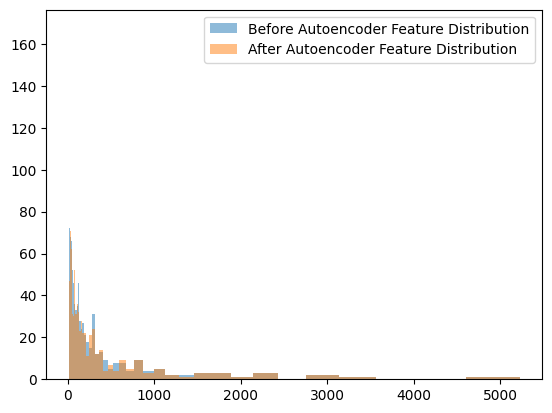

In [17]:
test_data_encoded = autoencoder.encode(test_data).detach()
test_data_decoded = autoencoder.decode(test_data_encoded).detach()
test_data_dict = dict()
test_data_dict['original'] = test_data
test_data_dict['decoded'] = test_data_decoded

print("Showing feature distribution from generated model")

def convert_to_binary(data):
    data[data >= 0.5] = 1.0
    data[data < 0.5] = 0.0
    return data

test_data_decoded_binary = convert_to_binary(test_data_decoded).detach()

print("Original Test Data Mean: ", test_data.mean())
print("After Autoencoder Test Data Mean ", test_data_decoded_binary.mean())


test_data_np = test_data.sum(axis=0).cpu().numpy()
test_data_decoded_np = test_data_decoded_binary.sum(axis=0).cpu().numpy()

max_count = max(test_data_np.max(), test_data_decoded_np.max())
bins = np.logspace(1.0, np.log10(max_count), num=50)

pyplot.hist(test_data_np, bins, alpha=0.5, label='Before Autoencoder Feature Distribution')
pyplot.hist(test_data_decoded_np, bins, alpha=0.5, label='After Autoencoder Feature Distribution')
pyplot.legend(loc='upper right')
pyplot.show()

## Model Part 2 - UNet (Continuous-Time Diffusion Model/Score Net)

###Overview
The synthetic generation process involves two different models:
- Autoencoder - Used to lower the dimensionality of the data
- Continuous-Time Diffusion Model - Used to generated synthetic data

The Autoencoder is used to lower the dimensionality from the original dataset (one feature per ICD code or 6,985 features) to 144 features.  This helps to capture relationships between related ICD codes and reduces the dimensionality of the output data that the continuous-time diffusion model must generate.

The Continuous-Time Diffusion Model (aka UNet aka Score Net) is used to generate the synthetic data.  It works in combination with a Variance Preserving Stochastic Differential Equation (VPSDE).  The VPSDE function is designed to take real data and convert real data into random noise in a controlled manner.  The VPSDE function converts the data into noise at continous time-steps between $0$ (completely real data) and $1$ (complete noise).

###UNet Configuration

**Model Architecture:**

Due to the complex nature of the model, it's difficult to describe it in a single table that captures each layer and their size/type/activation function.  Instead, we focus on describing how the model works and it's overarching architecture.

Let's assume that this noise is added over $n$ timesteps.  The Score Net/UNet is trained to take data with noise added to it at time $t_k$ (where $k$ is between 1 and $n$), and back-convert that to the data at time $t_{k-1}$ (before the noise was added).  To support this, the loss function is defined as the difference between the actual $t_{k-1}$ and the predicted $t_{k-1}$.

Therefore we are training the model to be able to convert noisy data into real data.  Once this training is complete, to generate synthetic data we generate random noise and plug it into the model using a ReverseSDE function (that is designed to remove noise using the model).  We start with noise at $t_n$ and move step-wise backwards - at each step the model telling us what real parameters it _thinks_ could represent the next step with noise added.  When we get to $t_0$ we have data that follows the same patterns as real data, but because it was built based on noise is completely synthetic.

In terms of architecture, the Continuous-Time Diffusion Model (aka UNet aka Score Net) is a UNet architecture based on the reduced dimensionality space provided by the autoencoder.  It has two down-sampling layers that progressively reduce the size of the input data using convolution.  Each of these down-sampling layers also has two residual blocks that allow data to skip parts of the model as needed.  Each residual block also incorporates self-attention.  SiLU ($sigmoid(x) * x$) is used as the activation function throughout this model.

**Training Objectives:**
- Loss Function: The loss function is a custom loss function designed to determine the loss between a predicted $t_{k-1}$ and an actual $t_{k-1}$.
- Optimiser: Adam with an adaptive learning rate.  The learning rate ($\lambda$) at epoch $t$ is defined by the exponential decay formula:

$$
\lambda(t) = \text{lr}_0 \cdot e^{-k \cdot t}
$$

where:
- $\text{lr}_0 = 0.5$ is the initial learning rate,
- $k = 0.1$ is the decay rate,
- $t$ is the epoch number.

**Other Info:**
The model is not pretrained, but weights are initialized using `torch.nn.init.xavier_uniform_`.

### Define UNet Class
UNet is trained to calculate how to move from noise to data at a given timestamp.  It is later instantiated as score_net.

In [18]:
# Modified from: https://github.com/aanaseer/ScoEHR/blob/main/scoehr/models/unet.py

class SiLU(nn.Module):
    def __init__(self):
        super().__init__()

    # noinspection PyMethodMayBeStatic
    def forward(self, x):
        return torch.sigmoid(x) * x


def group_norm(out_ch):
    return nn.GroupNorm(num_groups=32, num_channels=out_ch, eps=1e-6, affine=True)


def upsample(in_ch, with_conv):
    up = nn.Sequential()
    up.add_module("up_nn", nn.Upsample(scale_factor=2, mode="nearest"))
    if with_conv:
        up.add_module("up_conv", conv2d(in_ch, in_ch, kernel_size=(3, 3), stride=1))
    return up


def downsample(in_ch, with_conv):
    if with_conv:
        down = conv2d(in_ch, in_ch, kernel_size=(3, 3), stride=2)
    else:
        down = nn.AvgPool2d(2, 2)
    return down


class ResidualBlock(nn.Module):
    def __init__(
        self,
        in_ch,
        temb_ch,
        out_ch=None,
        conv_shortcut=False,
        dropout=0.0,
        normalize=group_norm,
        act=SiLU(),
    ):
        super().__init__()
        self.in_ch = in_ch
        self.temb_ch = temb_ch
        self.out_ch = out_ch if out_ch is not None else in_ch
        self.conv_shortcut = conv_shortcut
        self.dropout = dropout
        self.act = act

        self.temb_proj = dense(temb_ch, out_ch)
        self.norm1 = normalize(in_ch) if normalize is not None else nn.Identity()
        self.conv1 = conv2d(in_ch, out_ch)
        self.norm2 = normalize(out_ch) if normalize is not None else nn.Identity()
        self.dropout = nn.Dropout2d(p=dropout) if dropout > 0.0 else nn.Identity()
        self.conv2 = conv2d(out_ch, out_ch, init_scale=0.0)
        if in_ch != out_ch:
            if conv_shortcut:
                self.shortcut = conv2d(in_ch, out_ch)
            else:
                self.shortcut = conv2d(in_ch, out_ch, kernel_size=(1, 1), padding=0)
        else:
            self.shortcut = nn.Identity()

    def forward(self, x, temb):
        # forward conv1
        h = x
        h = self.act(self.norm1(h))
        h = self.conv1(h)

        # add in timestep embedding
        h = h + self.temb_proj(self.act(temb))[:, :, None, None]

        # forward conv2
        h = self.act(self.norm2(h))
        h = self.dropout(h)
        h = self.conv2(h)

        # shortcut
        x = self.shortcut(x)

        # combine and return
        assert x.shape == h.shape
        return x + h


class SelfAttention(nn.Module):
    """
    copied modified from https://github.com/voletiv/self-attention-GAN-pytorch/blob/master/sagan_models.py#L29
    copied modified from https://github.com/hojonathanho/diffusion/blob/master/diffusion_tf/models/unet.py#L66
    """

    def __init__(self, in_channels, normalize=group_norm):
        super().__init__()
        self.in_channels = in_channels
        self.attn_q = conv2d(
            in_channels, in_channels, kernel_size=1, stride=1, padding=0
        )
        self.attn_k = conv2d(
            in_channels, in_channels, kernel_size=1, stride=1, padding=0
        )
        self.attn_v = conv2d(
            in_channels, in_channels, kernel_size=1, stride=1, padding=0
        )
        self.proj_out = conv2d(
            in_channels, in_channels, kernel_size=1, stride=1, padding=0, init_scale=0.0
        )
        self.softmax = nn.Softmax(dim=-1)
        if normalize is not None:
            self.norm = normalize(in_channels)
        else:
            self.norm = nn.Identity()

    # noinspection PyUnusedLocal
    def forward(self, x, temp=None):
        """t is not used"""
        _, C, H, W = x.size()

        h = self.norm(x)
        q = self.attn_q(h).view(-1, C, H * W)
        k = self.attn_k(h).view(-1, C, H * W)
        v = self.attn_v(h).view(-1, C, H * W)

        attn = torch.bmm(q.permute(0, 2, 1), k) * (int(C) ** (-0.5))
        attn = self.softmax(attn)

        h = torch.bmm(v, attn.permute(0, 2, 1))
        h = h.view(-1, C, H, W)
        h = self.proj_out(h)

        assert h.shape == x.shape
        return x + h


def _calculate_correct_fan(tensor, mode):
    """
    copied and modified from https://github.com/pytorch/pytorch/blob/master/torch/nn/init.py#L337
    """
    mode = mode.lower()
    valid_modes = ["fan_in", "fan_out", "fan_avg"]
    if mode not in valid_modes:
        raise ValueError(
            "Mode {} not supported, please use one of {}".format(mode, valid_modes)
        )

    fan_in, fan_out = _calculate_fan_in_and_fan_out(tensor)
    return fan_in if mode == "fan_in" else fan_out


def kaiming_uniform_(tensor, gain=1.0, mode="fan_in"):
    r"""Fills the input `Tensor` with values according to the method
    described in `Delving deep into rectifiers: Surpassing human-level
    performance on ImageNet classification` - He, K. et al. (2015), using a
    uniform distribution. The resulting tensor will have values sampled from
    :math:`\mathcal{U}(-\text{bound}, \text{bound})` where

    .. math::
        \text{bound} = \text{gain} \times \sqrt{\frac{3}{\text{fan\_mode}}}

    Also known as He initialization.

    Args:
        tensor: an n-dimensional `torch.Tensor`
        gain: multiplier to the dispersion
        mode: either ``'fan_in'`` (default) or ``'fan_out'``. Choosing ``'fan_in'``
            preserves the magnitude of the variance of the weights in the
            forward pass. Choosing ``'fan_out'`` preserves the magnitudes in the
            backwards pass.
    Examples:
        >>> w = torch.empty(3, 5)
        >>> nn.init.kaiming_uniform_(w, mode='fan_in')
    """
    fan = _calculate_correct_fan(tensor, mode)
    var = gain / max(1.0, fan)
    bound = math.sqrt(3.0 * var)  # Calculate uniform bounds from standard deviation
    with torch.no_grad():
        return tensor.uniform_(-bound, bound)


def variance_scaling_init_(tensor, scale):
    return kaiming_uniform_(tensor, gain=1e-10 if scale == 0 else scale, mode="fan_avg")


def dense(in_channels, out_channels, init_scale=1.0):
    lin = nn.Linear(in_channels, out_channels)
    variance_scaling_init_(lin.weight, scale=init_scale)
    nn.init.zeros_(lin.bias)
    return lin


def conv2d(
    in_planes,
    out_planes,
    kernel_size=(3, 3),
    stride=1,
    dilation=1,
    padding=1,
    bias=True,
    padding_mode="zeros",
    init_scale=1.0,
):
    conv = nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=kernel_size,
        stride=stride,
        padding=padding,
        dilation=dilation,
        bias=bias,
        padding_mode=padding_mode,
    )
    variance_scaling_init_(conv.weight, scale=init_scale)
    if bias:
        nn.init.zeros_(conv.bias)
    return conv


def get_sinusoidal_positional_embedding(
    timesteps: torch.LongTensor, embedding_dim: int
):
    """
    Copied and modified from
        https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/nn.py#L90

    From Fairseq in
        https://github.com/pytorch/fairseq/blob/master/fairseq/modules/sinusoidal_positional_embedding.py#L15
    Build sinusoidal embeddings.
    This matches the implementation in tensor2tensor, but differs slightly
    from the description in Section 3.5 of "Attention Is All You Need".
    """
    assert len(timesteps.size()) == 1
    timesteps = timesteps.to(torch.get_default_dtype())
    device = timesteps.device

    half_dim = embedding_dim // 2
    emb = math.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, dtype=torch.float, device=device) * -emb)
    emb = timesteps[:, None] * emb[None, :]
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)  # bsz x embd
    if embedding_dim % 2 == 1:  # zero pad
        emb = F.pad(emb, (0, 1), "constant", 0)
    assert list(emb.size()) == [timesteps.size(0), embedding_dim]
    return emb


class TimestepEmbedding(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, act=SiLU()):
        super().__init__()

        self.embedding_dim = embedding_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim

        self.main = nn.Sequential(
            dense(embedding_dim, hidden_dim),
            act,
            dense(hidden_dim, output_dim),
        )

    def forward(self, temp):
        temb = get_sinusoidal_positional_embedding(temp, self.embedding_dim)
        temb = self.main(temb)
        return temb


class UNet(nn.Module):
    def __init__(
        self,
        input_channels,
        encoded_latent_embedding_dim,  # eg 64
        ch,
        output_channels=None,
        ch_mult=(1, 2, 4, 8),
        num_res_blocks=2,
        attn_resolutions=(16,),
        dropout=0.0,
        resamp_with_conv=True,
        act=SiLU(),
        normalize=group_norm,
    ):
        super().__init__()
        self.input_channels = input_channels
        self.encoded_latent_embedding_dim = encoded_latent_embedding_dim  # eg 64
        self.input_height = int(np.sqrt(self.encoded_latent_embedding_dim))  # eg 8
        self.ch = ch
        self.output_channels = output_channels = (
            input_channels if output_channels is None else output_channels
        )
        self.ch_mult = ch_mult
        self.num_res_blocks = num_res_blocks
        self.attn_resolutions = attn_resolutions
        self.dropout = dropout
        self.resamp_with_conv = resamp_with_conv
        self.act = act
        self.normalize = normalize

        # init
        self.num_resolutions = num_resolutions = len(ch_mult)
        in_ht = self.input_height
        in_ch = input_channels
        temb_ch = ch * 4
        assert (
            in_ht % 2 ** (num_resolutions - 1) == 0
        ), "input_height doesn't satisfy the condition"

        # Timestep embedding
        self.temb_net = TimestepEmbedding(
            embedding_dim=ch,
            hidden_dim=temb_ch,
            output_dim=temb_ch,
            act=act,
        )

        # Downsampling
        self.begin_conv = conv2d(in_ch, ch)
        unet_chs = [ch]
        in_ht = in_ht
        in_ch = ch
        down_modules = []
        for i_level in range(num_resolutions):
            # Residual blocks for this resolution
            block_modules = {}
            out_ch = ch * ch_mult[i_level]
            for i_block in range(num_res_blocks):
                block_modules["{}a_{}a_block".format(i_level, i_block)] = ResidualBlock(
                    in_ch=in_ch,
                    temb_ch=temb_ch,
                    out_ch=out_ch,
                    dropout=dropout,
                    act=act,
                    normalize=normalize,
                )
                if in_ht in attn_resolutions:
                    block_modules[
                        "{}a_{}b_attn".format(i_level, i_block)
                    ] = SelfAttention(out_ch, normalize=normalize)
                unet_chs += [out_ch]
                in_ch = out_ch
            # Downsample
            if i_level != num_resolutions - 1:
                block_modules["{}b_downsample".format(i_level)] = downsample(
                    out_ch, with_conv=resamp_with_conv
                )
                in_ht //= 2
                unet_chs += [out_ch]
            # convert list of modules to a module list, and append to a list
            down_modules += [nn.ModuleDict(block_modules)]
        # convert to a module list
        self.down_modules = nn.ModuleList(down_modules)

        # Middle
        mid_modules = []
        mid_modules += [
            ResidualBlock(
                in_ch,
                temb_ch=temb_ch,
                out_ch=in_ch,
                dropout=dropout,
                act=act,
                normalize=normalize,
            )
        ]
        mid_modules += [SelfAttention(in_ch, normalize=normalize)]
        mid_modules += [
            ResidualBlock(
                in_ch,
                temb_ch=temb_ch,
                out_ch=in_ch,
                dropout=dropout,
                act=act,
                normalize=normalize,
            )
        ]
        self.mid_modules = nn.ModuleList(mid_modules)

        # Upsampling
        up_modules = []
        for i_level in reversed(range(num_resolutions)):
            # Residual blocks for this resolution
            block_modules = {}
            out_ch = ch * ch_mult[i_level]
            for i_block in range(num_res_blocks + 1):
                block_modules["{}a_{}a_block".format(i_level, i_block)] = ResidualBlock(
                    in_ch=in_ch + unet_chs.pop(),
                    temb_ch=temb_ch,
                    out_ch=out_ch,
                    dropout=dropout,
                    act=act,
                    normalize=normalize,
                )
                if in_ht in attn_resolutions:
                    block_modules[
                        "{}a_{}b_attn".format(i_level, i_block)
                    ] = SelfAttention(out_ch, normalize=normalize)
                in_ch = out_ch
            # Upsample
            if i_level != 0:
                block_modules["{}b_upsample".format(i_level)] = upsample(
                    out_ch, with_conv=resamp_with_conv
                )
                in_ht *= 2
            # convert list of modules to a module list, and append to a list
            up_modules += [nn.ModuleDict(block_modules)]
        # conver to a module list
        self.up_modules = nn.ModuleList(up_modules)
        assert not unet_chs

        # End
        self.end_conv = nn.Sequential(
            normalize(in_ch),
            self.act,
            conv2d(in_ch, output_channels, init_scale=0.0),
        )

    # noinspection PyMethodMayBeStatic
    def _compute_cond_module(self, module, x, temp):
        for m in module:
            x = m(x, temp)
        return x

    # noinspection PyArgumentList,PyShadowingNames
    def forward(self, x, temp):
        # Init
        x = x.view(-1, 1, self.input_height, self.input_height)
        temp = temp.view(
            -1,
        )
        B, C, H, W = x.size()
        # Timestep embedding
        temb = self.temb_net(temp)
        assert list(temb.shape) == [B, self.ch * 4]
        # Downsampling
        hs = [self.begin_conv(x)]
        for i_level in range(self.num_resolutions):
            # Residual blocks for this resolution
            block_modules = self.down_modules[i_level]
            for i_block in range(self.num_res_blocks):
                resnet_block = block_modules["{}a_{}a_block".format(i_level, i_block)]
                h = resnet_block(hs[-1], temb)
                if h.size(2) in self.attn_resolutions:
                    attn_block = block_modules["{}a_{}b_attn".format(i_level, i_block)]
                    h = attn_block(h, temb)
                hs.append(h)
            # Downsample
            if i_level != self.num_resolutions - 1:
                downsample = block_modules["{}b_downsample".format(i_level)]
                hs.append(downsample(hs[-1]))

        # Middle
        h = hs[-1]
        h = self._compute_cond_module(self.mid_modules, h, temb)

        # Upsampling
        for i_idx, i_level in enumerate(reversed(range(self.num_resolutions))):
            # Residual blocks for this resolution
            block_modules = self.up_modules[i_idx]
            for i_block in range(self.num_res_blocks + 1):
                resnet_block = block_modules["{}a_{}a_block".format(i_level, i_block)]
                h = resnet_block(torch.cat([h, hs.pop()], axis=1), temb)
                if h.size(2) in self.attn_resolutions:
                    attn_block = block_modules["{}a_{}b_attn".format(i_level, i_block)]
                    h = attn_block(h, temb)
            # Upsample
            if i_level != 0:
                upsample = block_modules["{}b_upsample".format(i_level)]
                h = upsample(h)
        assert not hs

        # End
        h = self.end_conv(h)
        assert list(h.size()) == [x.size(0), self.output_channels, x.size(2), x.size(3)]
        h = h.view(-1, self.encoded_latent_embedding_dim)
        return h

### Define DenoisingScoreMatching Class
This can be thought of as the loss function for UNet (score_net).

In [19]:
# Modified from: https://github.com/aanaseer/ScoEHR/blob/main/scoehr/score_matching/dsm.py

"""Implements the denoising score matching objective along with two helper functions."""

def pad_to(self, x, stride):
    h, w = x.shape[-2:]
    if w % stride > 0:
        new_w = w + stride - w % stride
    else:
        new_w = w
    lh, uh = int((h - h) / 2), int(h - h) - int((h - h) / 2)
    lw, uw = int((new_w - w) / 2), int(new_w - w) - int((new_w - w) / 2)
    pads = (lw, uw, lh, uh)

    # zero-padding by default.
    # See others at https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.pad
    out = F.pad(x, pads, "constant", 0)

    return out, pads


def unpad(self, x, pad):
    if pad[0] + pad[1] > 0:
        x = x[:, pad[0] : -pad[1]]
    return x


class DenoisingScoreMatching(nn.Module):
    def __init__(self, sde, score_net, T=1.0, padding_required=False):
        super().__init__()
        self.sde = sde
        self.score_net = score_net
        self.T = T
        self.padding_required = padding_required

    @torch.enable_grad()
    def loss_fn(self, x):
        t = torch.linspace(1 / x.size(0) + 1e-3, 1 - 1 / x.size(0), x.size(0)) + (
            1 - 2 * torch.rand(x.size(0))
        ) * (1 / x.size(0))
        t = t.view(-1, 1).to(x)

        idx = torch.randperm(t.nelement())
        t = t.view(-1)[idx].view(t.size())

        perturbed_x, noise, std, g = self.sde.sample(x, t)

        if self.padding_required:
            perturbed_x, pads = pad_to(perturbed_x, 784)
        score_predictions = self.score_net(perturbed_x, t)
        if self.padding_required:
            score_predictions = unpad(score_predictions, pads)

        return ((score_predictions + noise / std) ** 2).view(x.size(0), -1).sum(
            1, keepdim=False
        ) * (std**2).squeeze()

### Define VPSDE (Variance Preserving Stochastic Differential Equation) Class
The VPSDE class is used to add noise to the data at each time stamp.

In [20]:
# Modified from: https://github.com/aanaseer/ScoEHR/blob/main/scoehr/score_matching/sde_library.py
"""Implementation for the VPSDE along with the associated Reverse SDE.
This file also contains a wrapper for SDE to be used with torchsde library.
"""

# This code is a modification of https://github.com/CW-Huang/sdeflow-light/blob/main/lib/sdes.py


class VPSDE(nn.Module):
    """Implements the VPSDE."""

    def __init__(self, beta_min=0.1, beta_max=20.0, T=1.0, t_epsilon=0.001):
        super().__init__()
        self.beta_min = beta_min
        self.beta_max = beta_max
        self.T = T
        self.t_epsilon = t_epsilon

    def beta(self, t):
        return self.beta_min + t * (self.beta_max - self.beta_min)

    def mean_weight(self, t):
        return torch.exp(
            -0.25 * t**2 * (self.beta_max - self.beta_min) - 0.5 * t * self.beta_min
        )

    def var(self, t):
        return 1.0 - torch.exp(
            -0.5 * t**2 * (self.beta_max - self.beta_min) - t * self.beta_min
        )

    def f(self, x, t):
        return -0.5 * self.beta(t) * x

    def g(self, x, t):
        return torch.ones_like(x) * self.beta(t) ** 0.5

    def sample(self, x0, t):
        mean = self.mean_weight(t) * x0
        std = torch.sqrt(self.var(t))
        noise = torch.randn_like(x0)
        perturbed_x = mean + (noise * std)
        return perturbed_x, noise, std, self.g(perturbed_x, t)

    def probability_flow_ode(self, t, x, score_net):
        return (
            self.f(x, self.T - t)
            - 0.5 * (self.g(x, self.T - t) ** 2) * score_net(x, self.T - t.squeeze())
        ) * -1

class WrapperForTorchSDE(nn.Module):
    """Wraps the SDE to be used with torchsde library."""

    def __init__(self, reverse_sde, noise_type="diagonal", sde_type="ito"):
        super().__init__()
        self.noise_type = noise_type
        self.sde_type = sde_type
        self.reverse_sde = reverse_sde

    def f(self, t, x):
        t = t.repeat(x.size(0)).view(-1, 1)
        return self.reverse_sde.drift(x, t)

    def g(self, t, x):
        t = t.repeat(x.size(0)).view(-1, 1)
        return self.reverse_sde.diffusion(x, t)

## Training Part 2 - UNet (Continuous-Time Diffusion Model/Score Net)

###Training Methodology
The model is trained with 50 epochs with a variable learning rate (described in the model section above).  As can be seen in the per-epoch training loss chart displayed when the next cell is run, the number of epochs to successfully train is likely lower (there appear to be diminishing returns after ~20 epochs), however 50 epochs does not appear to cause significant overfitting issues as the test loss never increases.


###Computational Requirements
The training process takes ~30 minutes when trained with a GPU (substantially longer on a CPU).  We were able to successfully train it on a machine with 16GB of RAM.

Because of the several-minute training time, by default this notebook is set to show stats from our training run (and load the model's parameters from the saved parameter file: `./saved_models/score_net.pt`).  If you'd like to change this to train it yourself, set `train_score_net_model = True`.  You can also overwrite our training parameters by setting `save_score_net_model = True`.

### Instantiate Score Net

In [21]:
# Modified from: https://github.com/aanaseer/ScoEHR/blob/main/scoehr/main.py

lr_score_net = 0.001
T = 1
padding_required = False

sde = VPSDE()
score_net = UNet(
    input_channels=1,
    encoded_latent_embedding_dim=enc_out_dim,
    ch=128,
    ch_mult=(1, 2, 2),
    num_res_blocks=2,
    attn_resolutions=(16,),
    resamp_with_conv=True,
    dropout=0,
)
score_net.apply(weights_init)
score_net.to(device)
loss_fn_instance_dsm = DenoisingScoreMatching(sde=sde, score_net=score_net, T=T, padding_required=padding_required)
optimiser_score_net = torch.optim.Adam(loss_fn_instance_dsm.parameters(), lr=lr_score_net)

### Train Score Net

===> Loading model
===> Showing stats from loaded model


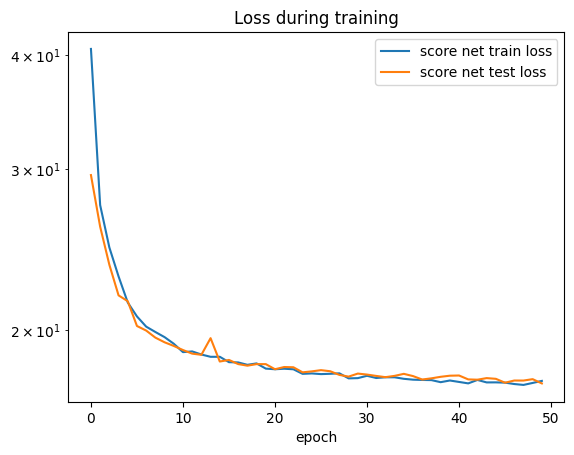

In [22]:
# Modified from: https://github.com/aanaseer/ScoEHR/blob/main/scoehr/train/train_scorenet.py

train_score_net = False
save_score_net_model = False

n_epochs_score_net = 50

if train_score_net:
    print(f"==> Training the score net with {n_epochs_score_net} epochs.")
    lr_0 = 0.5  # initial learning rate
    k = 0.1    # decay rate

    def lambda_func(t):
        return lr_0 * np.exp(-k * t)
    scheduler = lr_scheduler.LambdaLR(optimiser_score_net, lr_lambda=lambda_func)

    start_time = time.time()
    train_loss_list = []
    test_loss_list = []
    for epoch in range(n_epochs_score_net):
        epoch_loss = 0
        for x in tqdm.tqdm(train_dataloader_encoded):
            optimiser_score_net.zero_grad()
            loss = loss_fn_instance_dsm.loss_fn(x).mean()
            epoch_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(score_net.parameters(), 1)
            optimiser_score_net.step()

        avg_loss = epoch_loss / len(train_dataloader_encoded)

        train_loss_list.append(avg_loss)

        scheduler.step()

        time_elapsed = time.time() - start_time
        print(f"Epoch: {epoch+1}  |  Total Time: {time_elapsed:.2f}s | Train Loss: {avg_loss:.5f}")

        epoch_loss = 0
        with torch.no_grad():
            for x in tqdm.tqdm(test_dataloader_encoded):
                loss = loss_fn_instance_dsm.loss_fn(x).mean()
                epoch_loss += loss.item()

        avg_loss = epoch_loss / len(test_dataloader_encoded)

        test_loss_list.append(avg_loss)

        time_elapsed = time.time() - start_time
        print(f"Epoch: {epoch+1}  |  Total Time: {time_elapsed:.2f}s | Test Loss: {avg_loss:.5f}")

    print("==> Score net training completed.")
    plt.plot(train_loss_list, label='score net train loss')
    plt.plot(test_loss_list, label='score net test loss')
    plt.xlabel('epoch')
    plt.title('Loss during training')
    plt.legend()
    plt.yscale("log")
    plt.show()
    loss_list = dict()
    loss_list['train_loss_list'] = train_loss_list
    loss_list['test_loss_list'] = test_loss_list
    with open('./stats/score_net.pkl', 'wb') as file:
        pickle.dump(loss_list, file, -1)
    scorenet_model_path = "./saved_models/score_net.pt"
    if save_score_net_model:
        torch.save({'model_state_dict': score_net.state_dict()}, scorenet_model_path)
else:
    print("===> Loading model")
    scorenet_model_path = "./saved_models/score_net.pt"
    checkpoint = torch.load(scorenet_model_path, map_location=torch.device(device))
    score_net.load_state_dict(checkpoint['model_state_dict'])
    print("===> Showing stats from loaded model")
    with open('./stats/score_net.pkl', 'rb') as file:
        loss_list = pickle.load(file)
    train_loss_list = loss_list['train_loss_list']
    test_loss_list = loss_list['test_loss_list']
    plt.plot(train_loss_list, label='score net train loss')
    plt.plot(test_loss_list, label='score net test loss')
    plt.xlabel('epoch')
    plt.title('Loss during training')
    plt.legend()
    plt.yscale("log")
    plt.show()

## Generate Synthetic Data
Once the model is trained, it can be used to generate synthetic data that can be compared to the original data to determine if it is statistically similar while still protecting the privacy of the original patients.  The generation process is described in the Score Net model section.

Note: The generation of synthetic data takes ~45 minutes with a GPU.  By default, instead of generating this data instead pre-generated data is loaded and used.  You can change this by setting `generate_data = True`.

### Define ReverseSDE Class
The ReverseSDE class is used to remove noise from the data at each time stamp based on the score_net weights.

In [23]:
# Modified from: https://github.com/aanaseer/ScoEHR/blob/main/scoehr/score_matching/sde_library.py

class ReverseSDE(nn.Module):
    """Implements the reverse SDE."""

    def __init__(self, sde, score_net, T=1.0):
        super().__init__()
        self.sde = sde
        self.score_net = score_net
        self.T = T

    def drift(self, x, t):
        dt = -1
        return (
            self.sde.f(x, self.T - t)
            - (self.sde.g(x, self.T - t) ** 2) * self.score_net(x, self.T - t.squeeze())
        ) * dt

    def diffusion(self, x, t):
        return self.sde.g(x, self.T - t)  # Actual

### Generate the Synthetic Data

In [24]:
# Modified from: https://github.com/aanaseer/ScoEHR/blob/main/scoehr/main.py

generate_data = False
save_generated_data = False

if generate_data:
    time_steps = 25
    num_samples_to_generate = batch_size * 10

    print("==> Commencing reverse solve using torchsde Euler Maruyama.")

    reverse_sde = ReverseSDE(sde=sde, score_net=score_net, T=T)
    torchsde_SDE = WrapperForTorchSDE(reverse_sde=reverse_sde, noise_type="diagonal", sde_type="ito")
    ts = torch.linspace(0, 1, time_steps + 1) * reverse_sde.T
    ts = ts.to(device)
    with torch.no_grad():
        assert (
            num_samples_to_generate >= batch_size
        ), "Num to generate should be greater than or equal to batch size."
        batch_iter = math.ceil(num_samples_to_generate / batch_size)
        print(f"==> Able to generate {batch_iter * batch_size} samples.")

        xs_batches = []
        for i in range(0, batch_iter):
            print(f"==> Batch {i + 1} out of {batch_iter}.")
            x_0 = torch.randn(batch_size, enc_out_dim, device=device)
            x_batch_solved = torchsde.sdeint(torchsde_SDE, x_0, ts, method="euler")
            with torch.no_grad():
                print(
                    f"==> Decoding data generated in batch {i + 1} out of {batch_iter}."
                )
                x_batch_solved = torch.stack([x_batch_solved])
                for x_encoded in x_batch_solved:
                    out = autoencoder.decode(x_encoded.to(device))
                    out = out.cpu().detach()
                    xs_batches.append(out)
                    del out
                    torch.cuda.empty_cache()

        xs = torch.cat(
            xs_batches, 1
        )  # this requires xs_batches = [tensor, tensor,..]

        print("==> Reverse solve using torchsde Euler Maruyama completed.")

    xs_decoded = xs.clone().detach()  # torch.Size([101, 20, 625])
    print("==> Generated samples have been decoded.")
    print("==> Converting decoded generated samples to binary data.")

    xs = convert_to_binary(data=xs_decoded)

    print("==> Binary data conversion completed.")


    generated_data_at_every_time_step = xs.numpy()
    generated_data_final = generated_data_at_every_time_step[-1]

    if save_generated_data:
        print("==> Saving generated data.")
        np.savez_compressed('./generated_data/data.npz', a=generated_data_final)
        print("Generated data saved to ./generated_data/data.npz")

else:
    data = np.load('./generated_data/data.npz')
    generated_data_final = data['a']
    print("Loaded data")

Loaded data


## Evaluation

The original paper looked at three types of Metrics
1. Quantitative Metrics
2. Qualitative Metrics
3. Privacy Metrics

### 1. Quantitative Metrics

**1.1 Dimensional Distribution Metric**

Assessing if marginal distributions in real data are captured by the synthetic data. ie, for a given category of data, such as age, independent of other variables, the distribution is expected.

Binary Data:

$$\boldsymbol{DWM} = \sum_{i=1}^N \vert 	\frac{1}{n_d} \sum_{j=1}^{n_d} {d}_j,_i - \hat{d}_j,_i \vert$$

Continuous Variable Data:

$$\boldsymbol{DEM} = \sum_{i=1}^N \frac{1}{n_c} \sum_{j=1}^{n_c} \vert {c}_j,_i - \hat{c}_j,_i \vert$$

Total Score:

$$\frac{DWM + DEM}{N}$$

A lower value indicates that the real and synthetic data have similar marginal relationships.

---
Results found in the paper:

Model | MIMIC-III Dataset | ED EHR Dataset
--- | --- | ---
medGAN | 0.0019 $\pm$ 0.0001 | 0.012 $\pm$ 0.001 |
medBGAN | 0.0016 $\pm$ 0.0001 | 0.014 $\pm$ 0.001 |
medWGAN | 0.0025 $\pm$ 0.0001 | 0.0088 $\pm$ 0.0001 |
ScoEHR | 0.0029 $\pm$ 0.0001 | 0.0037 $\pm$ 0.0001 |

In [25]:
real = test_data[0:generated_data_final.shape[0]].to("cpu").detach()
synthetic = generated_data_final

#Note: Because this is entirely binary data, DEM is not needed
DWM = torch.sum(torch.abs(torch.mean(real - synthetic, axis=0)))
DDM = DWM / len(real)
DDM = DDM.item()
print(f"Dimensional Distribution Metric: {DDM}")
DDM_original = 0.0029
DDM_compare = round(((DDM - DDM_original) / abs(DDM_original)) * 100,2)
if (DDM_compare < 0):
  print(f"Recreated results have {abs(DDM_compare)}% better marginal relationships than the original.")
elif ((DDM_compare > 0)):
  print(f"Recreated results have {DDM_compare}% worse marginal relationships than the original.")
else:
  print("Recreated results have the same marginal relationships as the original.")

Dimensional Distribution Metric: 0.0011906431755051017
Recreated results have 58.94% better marginal relationships than the original.


**1.2 Pairwise Correlation Difference**

Assessing if the correlations in the real and synthetic datasets are similar. The Pearson Correlation Matrices are found for the real and sythetic data which are used to compute the Frobenius Norm of the difference.

$$PCD = \Vert Corr(D) - Corr(\hat D) \Vert_F$$

The closer PCD is to zero, the better the inter-dimensional relationships are caputred by the synthetic data.

---
Results found in the paper:

Model | MIMIC-III Dataset | ED EHR Dataset
--- | --- | ---
medGAN | 120 $\pm$ 8 | 24.1 $\pm$ 0.2 |
medBGAN | 146 $\pm$ 6 | 20.7 $\pm$ 0.5 |
medWGAN | 22.1 $\pm$ 0.4 | 15.2 $\pm$ 0.3 |
ScoEHR | 21.8 $\pm$ 0.3 | 33.6 $\pm$ 0.2 |

In [26]:
corr_real = torch.corrcoef(real)
corr_synthetic = torch.corrcoef(torch.from_numpy(synthetic))

#This allows us to ignore the rows and columns with no variance (the nan values)
corr_real[torch.isnan(corr_real)] = 0
corr_synthetic[torch.isnan(corr_synthetic)] = 0

PCD = torch.norm(corr_real - corr_synthetic).item()
PCD_original = 21.8
PCD_compare = round(((PCD - PCD_original) / abs(PCD_original)) * 100,2)
print(f"PCD: {PCD}")
if (PCD_compare < 0):
  print(f"Recreated results have {abs(PCD_compare)}% better inter-dimensional relationships than the original.")
elif ((PCD_compare > 0)):
  print(f"Recreated results have {PCD_compare}% worse inter-dimensional relationships than the original.")
else:
  print("Recreated results have the same marginal inter-dimensional as the original.")

PCD: 984.2593994140625
Recreated results have 4414.95% worse inter-dimensional relationships than the original.


**1.3 Marginal and Correlation Similarity**

Assessing the similarity of the latent structure of the real and synthetic datsets. This is obtained by concatenating both datasets and using k-means clustering to determine 'G' clusters.

$$U = log(\frac{1}{G})\sum_{j=1}^G\lbrack \frac{n_j^R}{n_j} - c \rbrack ^2$$
* $G$ is the number of clusters

* ${n_j^R}$ is the number of samples from the real dataset

* ${n_j^S}$ is the number of samples from the synthetic dataset

* ${n_j}$ is the number of samples in the j-th cluster
* $c$ is $\frac{n^R}{n^R + n^S} $


A lower log-cluster score indicates more similarity between the synthetic and real data.

---
Results found in the paper:

Model | MIMIC-III Dataset | ED EHR Dataset
--- | --- | ---
medGAN | -2.9 $\pm$ 0.1 | -3.7 $\pm$ 0.3 |
medBGAN | -3.2 $\pm$ 0.1 | -2.5 $\pm$ 0.2 |
medWGAN | -5.4 $\pm$ 0.2 | -6.1 $\pm$ 0.4 |
ScoEHR | -6.0 $\pm$ 0.1 | -7.8 $\pm$ 0.5 |

In [27]:
# Waiting to implement until original paper can be properly recreated so proper number of clusters can be determined

**1.4 Synthetic Ranking Agreement**

Assessing the utility of the synethic data for use in downstream machine learning tasks by comparing results obtained through synthetic data and results obtained when using real data. This is obtained by training and testing a machine learning model using both real and synthetic data and finding their respective AUROC.

$$SRA = \frac{1}{L(L-1)}\sum_{j=1}^L\sum_{k\ne j} \mathbb{I} ((A_j-A_k)(B_j-B_k)) > 0$$

* $L$ is the number of machine learning models
* $A$ are a set of AUROC values for models trained and tested with real data
* $B$ are  a set of AUROC values for
 models trained and tested with synthetic data
* $\mathbb{I}$ is the indicator function.

A higher SRA indicates similarity in machine learning tasks.

---
Results found in the paper:

Model | MIMIC-III Dataset | ED EHR Dataset
--- | --- | ---
medGAN | 0.83 $\pm$ 0.02 | 0.81 $\pm$ 0.02 |
medBGAN | 0.86 $\pm$ 0.03 | 0.85 $\pm$ 0.03 |
medWGAN | 0.81 $\pm$ 0.03 | 0.83 $\pm$ 0.04 |
ScoEHR | 0.87 $\pm$ 0.02 | 0.86 $\pm$ 0.03 |

In [28]:
# Waiting to implement until original paper can be properly recreated so proper machine learning task can be determined

# #TODO: Consider using PyHealth to run basic, quick tasks and get AUROC
# A = None
# B = None

# #https://www.statlect.com/fundamentals-of-probability/indicator-functions
# SRA = None
# print(f"Synthetic Ranking Agreement: {SRA}")
# SRA_original = 0.87
# SRA_compare = round(((SRA - SRA_original) / abs(SRA_original)) * 100,2)
# if (SRA_compare > 0):
#   print(f"Recreated results have {SRA_compare}% better similarity in machine learning tasks than the original.")
# elif ((SRA_compare < 0)):
#   print(f"Recreated results have {abs(SRA_compare)}% worse similarity in machine learning tasks than the original.")
# else:
#   print("Recreated results have the same similarity in machine learning tasks as the original.")

### 2. Qualitative Metrics
**Clinician Review**

A random mixed set of real and synthetic data was inspected to evaluate realism.

---

In the paper, 100 synthetic patients and 100 real patients were combined and label as 'realistic' or 'unrealistic' by 3 board certified clinicians.

*   If a patient is considered 'unrealistic' if one clinician labeled them as such, 81% of real patients were labeled as real and 81% of synthetic patients were labeled as real
*   If a patient is considered realistic if at least one clinician labeled them as realistic, 100% of real and synthetic patients were labeled realistic
*   If a patient is considered realistic only if a majority of the 3 clinicians agreed, 93% of real patients were labeled as real and 95% of the synthetic patients were labeled as real
---
Note: We are not recreating this metric due to lack of connections with board certified clinicians. This metric is referenced for completeness.


### 3. Privacy

Assessing if, given a random sample of synthetic data and training data, it could be determined with likely probability that someone's data was used in the training. This is determined by calculating the Cosine Similarity between the real and synthetic data. If the probabliity is 50% or higher, the patients privacy is considered to be compromised.

In [29]:
cosine_sim = torch.nn.functional.cosine_similarity(real, torch.from_numpy(synthetic), dim=1)
print(f"Confidence in determining if someone's data was used in training: {cosine_sim}")

print(f"Privacy is protected for {(cosine_sim <= 0.5).sum()} / {cosine_sim.shape[0]} patients")
print(f"Privacy is NOT protected for {(cosine_sim > 0.5).sum()} / {cosine_sim.shape[0]} patients")

Confidence in determining if someone's data was used in training: tensor([0.0000, 0.0000, 0.0000,  ..., 0.6124, 0.0000, 0.2649])
Privacy is protected for 5068 / 5120 patients
Privacy is NOT protected for 52 / 5120 patients


#Discussion


**1. Results**

Desipte some computaitonal limitations, we have been able to implement the preprocessing and model training on the full (MIMIC-III) data set, generate synthetic data, and test several of the evaluation metrics:

- **Metric 1.1 (Dimensional Distribution Metric):**
 - Paper: $0.0029\pm0.0001$
 - Our Results: $0.0012$
- **Metric 1.2 (Pairwise Correlation Difference):**
 - Paper: $21.8\pm0.3$
 - Our Results: ~$900$
- **Metric 3 (Privacy):**
 - Paper: Privacy protected for 100% of patients
 - Our Results: Privacy protected for 99% of patients


**2. Analysis**

We have found the paper to be very accessible yet detailed, making it relatively painless to reproduce. Additionally, having access to the code and dataset used in the original paper helps immensly in reproducing results. So far we have found the most difficult part to be address compute limitations and determining how to implement fine details of the paper.  As a result we have had mixed results reproducing all of the metrics from the original paper.

- **Metric 1.1 (Dimensional Distribution Metric):** While not exactly the same, our results were at least within the same order of magnitude of the results in the paper ($0.0029\pm0.0001$ for the paper vs. $0.0012$ in our results) and in fact our results were better than those in the paper (lower is better).
- **Metric 1.2 (Pairwise Correlation Difference):** Our results were significantly worse than the original paper ($21.8\pm0.3$ in the paper vs. $~900$ in our results).
- **Metric 1.3 (Marginal and Correlation Similarity):** Not yet implemented as we are currently focusing on reviewing the other metrics.
- **Metric 1.4 (Synthetic Ranking Agreement):** Not yet implemented as we are currently focusing on reviewing the other metrics.
- **Metric 3 (Privacy):** Our results determine that privacy was protected for ~99% of patients while the paper indicated that privacy was protected for all patients.

Overall our metrics reveal that there is still a gap between our synthetic data and the synthetic data produced in the paper.

**3. Plan**

 We plan on further debugging our code to determine if we can get results closer to the paper.  We plan to do this both by testing different hyperparameters as well as using a count representation of each ICD code instead of binary data representation of them.  Both of these options were included in the original paper's code without a note as to which would yield better results).  We will next finish implementing the evaluation metrics, testing various abalations, and implement the Synthetic Ranking Agreement metric.

# References

1.   A.A. Naseer et al, ScoEHR: Generating Synthetic Electronic Health Records
using Continuous-time Diffusion Models, Proceedings of Machine Learning Research, 2023, 219:1–22, doi: https://static1.squarespace.com/static/59d5ac1780bd5ef9c396eda6/t/64d1aa32ed57852af9c0ad60/1691462195379/ID145_Research+Paper_2023.pdf
(doi url could not be found)

